In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)


In [2]:
# expensive hours: 8:00-16:00
source_1_price = np.ones(24)
source_1_price[8:16] = 2
source_1_price = np.tile(source_1_price,7)

# Multiply by 1.5 to get source 2 prices
source_2_price = 1.5 * source_1_price

In [3]:
# Hourly water demand
hourly_demand = np.array([
    2, 2, 2, 2, 3, 5, 10, 12, 10, 8, 6, 5, 5, 5, 5, 6, 7, 9, 10, 9, 6, 4, 3, 2
])
# Normalize: Daily demand is 1000
TOTAL_DAILY_DEMAND = 1000
hourly_demand = (hourly_demand / hourly_demand.sum()) * TOTAL_DAILY_DEMAND

# on day 7: less demand
hourly_demand = np.append(np.tile(hourly_demand,6), hourly_demand / 2)

## Your Code

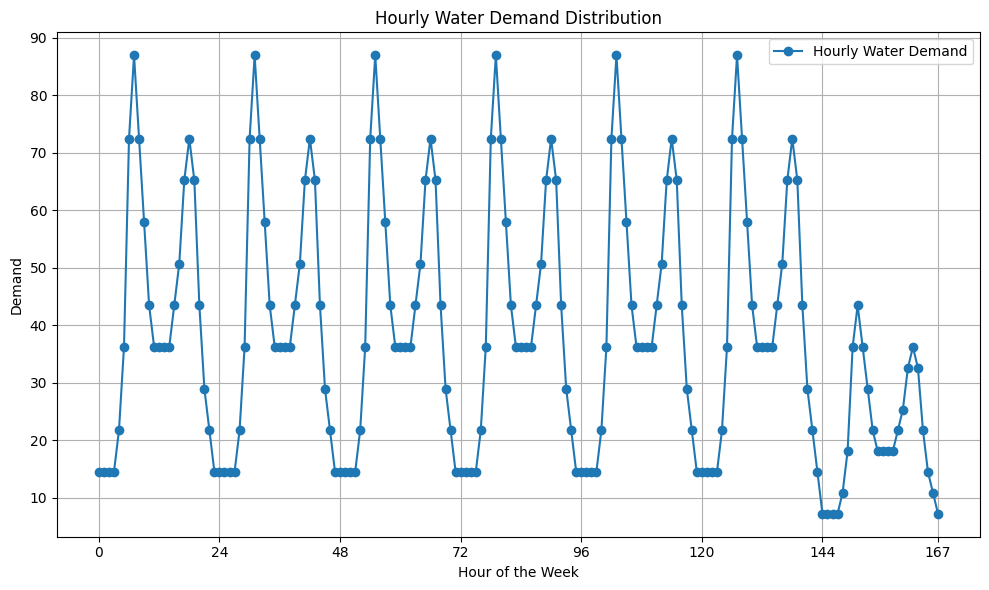

In [4]:
# Plot demand graph
def print_demand(hourly_demand):
    hours = np.arange(0, 168)  
    plt.figure(figsize=(10, 6))
    plt.plot(hours, hourly_demand, marker='o', label='Hourly Water Demand')
    plt.title('Hourly Water Demand Distribution')
    plt.xlabel('Hour of the Week')
    plt.ylabel('Demand')
    plt.xticks(hours)
    plt.xticks([i for i in range(168) if i % 24 == 0 or i == 167])
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.show()

print_demand(hourly_demand)

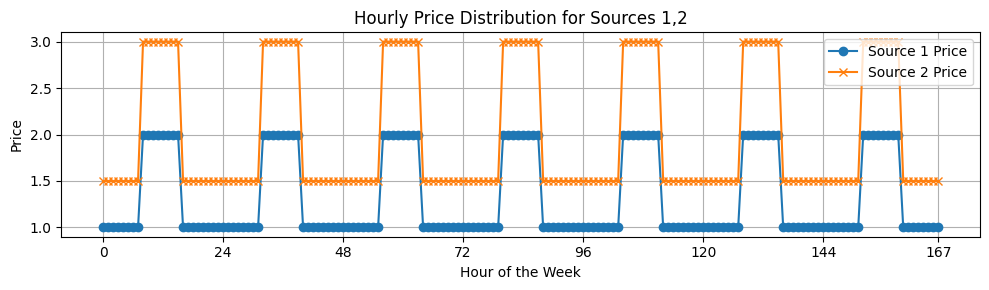

In [5]:
# Plot price {1,2} graph
plt.figure(figsize=(10, 3))
hours = np.arange(0, 168)  
plt.plot(hours, source_1_price, marker='o', label='Source 1 Price')
plt.plot(hours, source_2_price, marker='x', label='Source 2 Price')
plt.title('Hourly Price Distribution for Sources 1,2')
plt.xlabel('Hour of the Week')
plt.ylabel('Price')
plt.xticks([i for i in range(168) if i % 24 == 0 or i == 167])
plt.grid()
plt.legend()
plt.tight_layout()


plt.show()

In [6]:
# Size of the agent's pool
AGENT_WATER_VOLUME_MAX = 300

# Price of missing a 1 water unit of consumer: 
# e.g agent's water volume = 10, consumer demand = 20, price = (20-10) * PENALTY_PER_WATER_UNIT
PENALTY_PER_WATER_UNIT = 1000


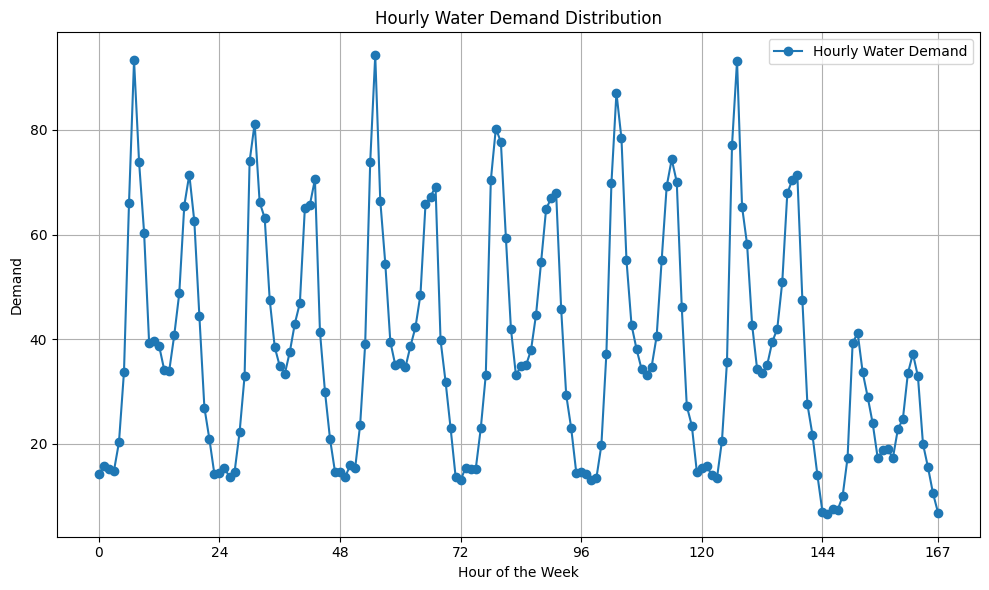

In [7]:
random_noise = np.random.uniform(0.9, 1.1, size=168)
hourly_demand_noised = hourly_demand * random_noise

print_demand(hourly_demand_noised)

In [8]:
def calculate_price(amount_to_buy: float, base_price: float) -> float:
    return amount_to_buy * base_price + 0.05 * base_price * (amount_to_buy -1) ** 2

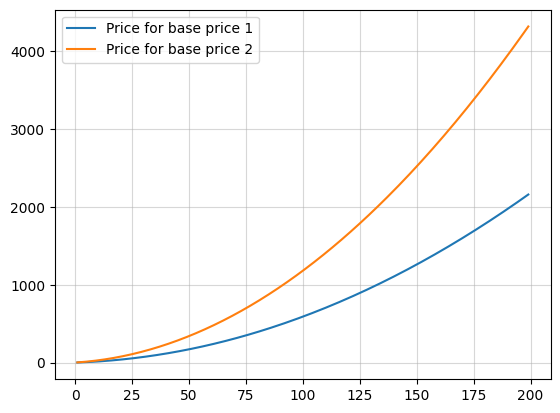

In [9]:
# price for base prices 1, 2
max_range = 200
ys1 = [calculate_price(i, 1) for i in range(1, max_range)]
ys2 = [calculate_price(i, 2) for i in range(1, max_range)]

plt.plot(range(1, max_range), ys1, label='Price for base price 1')
plt.plot(range(1, max_range), ys2, label='Price for base price 2')
plt.legend()
plt.grid(alpha=0.5) 
plt.show()


## Make Demand Great Again

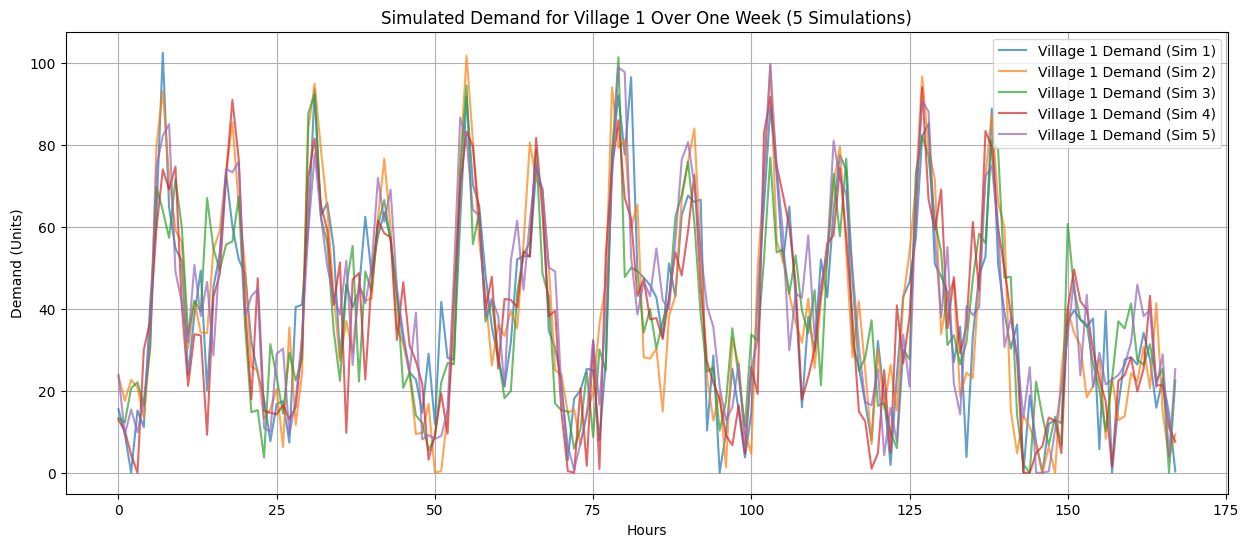

In [10]:
def hourly_demand_means():
    # Hourly water demand according to: 
    hourly_demand = np.array([
        2, 2, 2, 2, 3, 5, 10, 12, 10, 8, 6, 5, 5, 5, 5, 6, 7, 9, 10, 9, 6, 4, 3, 2
    ])
    # Normalize: Daily demand is 1000
    TOTAL_DAILY_DEMAND = 1000
    hourly_demand = (hourly_demand / hourly_demand.sum()) * TOTAL_DAILY_DEMAND

    # on day 7: less demand
    hourly_demand = np.append(np.tile(hourly_demand,6), hourly_demand / 2)
    return hourly_demand



def sample_demand(hour, std=10):
    # Sample from a normal distribution, ensure demand is non-negative
    hourly_demand = hourly_demand_means()
    mean_demand = hourly_demand[hour] # Mean demand follows a daily pattern, higher during the day (6 AM to 6 PM)
    return max(0, np.random.normal(mean_demand, std)) # When std_dev is relatively low we will get lines that are very very close to the original function.

# Function to sample and plot 5 simulations for a single village over one week
def sample_and_plot_5_weeks_demand_single_village(std_dev=10):
    hours = 168  # One week (168 hours)
    all_v1_demand = []

    # Generate demand for 5 different simulations of the same week
    for _ in range(5):
        v1_demand = []
        for hour in range(hours):
            v1_demand.append(sample_demand(hour, std_dev))
        all_v1_demand.append(v1_demand)

    # Plot all 5 simulations on the same graph for Village 1
    plt.figure(figsize=(15, 6))

    for i in range(5):
        plt.plot(all_v1_demand[i], label=f"Village 1 Demand (Sim {i+1})", alpha=0.7)

    plt.title("Simulated Demand for Village 1 Over One Week (5 Simulations)")
    plt.xlabel("Hours")
    plt.ylabel("Demand (Units)")
    plt.legend()
    plt.grid()
    plt.show()

# Call the function to generate and plot
sample_and_plot_5_weeks_demand_single_village()


In [11]:
# # Setting up the gymnasium environment
# !pip install -q swig
# !pip install -q mediapy
# !pip install -q gymnasium

In [12]:
# expensive hours: 8:00-16:00
source_1_price = np.ones(24)
source_1_price[8:16] = 2
source_1_price = np.tile(source_1_price,7)

# Multiply by 1.5 to get source 2 prices
source_2_price = 1.5 * source_1_price

## Actual Environment

In [13]:
import gym
from gym import spaces
import numpy as np

# Size of the agent's pool
AGENT_WATER_VOLUME_MAX = 300
# Price of missing a 1 water unit of consumer: 
# e.g agent's water volume = 10, consumer demand = 20, price = (20-10) * PENALTY_PER_WATER_UNIT
PENALTY_PER_WATER_UNIT = 1000

TOTAL_DAILY_DEMAND = 1000

# Price of agent selling 1 unit of water
FIXED_SELLING_PRICE = 10


def hourly_demand_means():
    # Hourly water demand according to: 
    hourly_demand = np.array([
        2, 2, 2, 2, 3, 5, 10, 12, 10, 8, 6, 5, 5, 5, 5, 6, 7, 9, 10, 9, 6, 4, 3, 2
    ])
    # Normalize: Daily demand is 1000
    hourly_demand = (hourly_demand / hourly_demand.sum()) * TOTAL_DAILY_DEMAND

    # on day 7: less demand
    hourly_demand = np.append(np.tile(hourly_demand,6), hourly_demand / 2)
    return hourly_demand



def sample_demand(hour, std=10):
    # Sample from a normal distribution, ensure demand is non-negative
    hourly_demand = hourly_demand_means()
    mean_demand = hourly_demand[hour] # Mean demand follows a daily pattern, higher during the day (6 AM to 6 PM)
    return max(0, np.random.normal(mean_demand, std)) # When std_dev is relatively low we will get lines that are very very close to the original function.


def calculate_price(amount_to_buy: float, base_price: float) -> float:
    return amount_to_buy * base_price + 0.05 * base_price * (amount_to_buy -1) ** 2


def get_water_prices():
    # expensive hours: 8:00-16:00
    source_1_price = np.ones(24)
    source_1_price[8:16] = 2
    source_1_price = np.tile(source_1_price,7)
    return source_1_price

class WaterSupplyEnv(gym.Env):

    def __init__(self):
        super().__init__()
        # State: [water_level, price_A, price_B, demand, current_hour]
        self.observation_space = spaces.Box(low=0, high=np.inf, shape=(5,))

        # Actions: [buy_from_A, buy_from_B, sell]
        self.action_space = spaces.Box(low=0, high=AGENT_WATER_VOLUME_MAX, shape=(3,))
        # Environment parameters
        self.max_water_level = AGENT_WATER_VOLUME_MAX
        self.fixed_selling_price = 10
        self.source_A_base_prices = get_water_prices()
        # Source B is more expensive
        self.source_B_base_prices = 1.5 * self.source_A_base_prices

        self.reset()

    def reset(self):
        self.current_hour = 0
        self.water_level = 100 # Initial water level
        self.demand = sample_demand(self.current_hour) # Initial demand
        self.price_A = self.source_A_base_prices[self.current_hour]
        self.price_B = self.source_B_base_prices[self.current_hour]
        return np.array([self.water_level,
                         self.price_A,
                         self.price_B,
                         self.demand,
                         self.current_hour])

    def step(self, action):
        buy_from_A, buy_from_B, sell = action

        # Calculate penalty for unmet demand
        unmet_demand_penalty = (self.demand - self.water_level) * PENALTY_PER_WATER_UNIT
        self.water_level = max(0, self.water_level - self.demand)

        # Ensure Sell is not more than available water.
        sell = min(self.water_level, sell)
        # Costs and revenues
        cost_A = calculate_price(buy_from_A, self.source_A_base_prices[self.current_hour])
        cost_B = calculate_price(buy_from_B, self.source_B_base_prices[self.current_hour])
        revenue = sell * self.fixed_selling_price

        # Update water stock
        self.water_level += buy_from_A + buy_from_B - sell

        # Calculate reward
        reward = (revenue - cost_A - cost_B) - unmet_demand_penalty # reward function

        # Ensure constraints
        self.water_level = min(self.max_water_level, self.water_level)  # Ensure water level is non-negative

        # Update state
        self.current_hour = (self.current_hour + 1) % 167
        self.demand = sample_demand(self.current_hour)
        self.price_A = self.source_A_base_prices[self.current_hour]
        self.price_B = self.source_B_base_prices[self.current_hour]

        state = np.array([self.water_level,
                          self.price_A,
                          self.price_B,
                          self.demand,
                          self.current_hour])
        done = False  # Define terminal conditions if necessary

        return state, reward, done, {}

    def render(self, mode="human", **kwargs):
        if kwargs.get("close", False):
            # If 'close' is passed, do nothing
            return
        print(f"Water Stock: {self.water_level}, Price A: {self.price_A}, Price B: {self.price_B}, Demand: {self.demand}")



In [14]:
def test_water_supply_env():
    # Initialize the environment
    env = WaterSupplyEnv()

    # Reset the environment
    state = env.reset()
    print("Initial State:", state)

    # Number of steps to simulate
    num_steps = 10

    # Simulate a few steps with random actions
    for step in range(num_steps):
        print(f"\n--- Step {step + 1} ---")
        
        # Random action within action space
        action = env.action_space.sample()
        print("Action:", action)
        
        # Take a step
        next_state, reward, done, info = env.step(action)
        
        # Print results
        print("Next State:", next_state)
        print("Reward:", reward)
        print("Done:", done)
        
        # Render environment
        env.render()

        if done:
            break

# Run the test
test_water_supply_env()


Initial State: [100.          1.          1.5         0.1850026   0.       ]

--- Step 1 ---
Action: [164.64405118 214.55680991 180.82901282]
Next State: [300.           1.           1.5         15.77379777   1.        ]
Reward: 95567.21100215011
Done: False
Water Stock: 300, Price A: 1.0, Price B: 1.5, Demand: 15.773797772296298

--- Step 2 ---
Action: [163.4649549  127.0964398  193.76823392]
Next State: [300.           1.           1.5          7.68223705   2.        ]
Reward: 283297.50846398505
Done: False
Water Stock: 300, Price A: 1.0, Price B: 1.5, Demand: 7.682237048439598

--- Step 3 ---
Action: [131.27616338 267.53190023 289.09882815]
Next State: [300.           1.           1.5         22.89918911   3.        ]
Reward: 288499.63924389664
Done: False
Water Stock: 300, Price A: 1.0, Price B: 1.5, Demand: 22.899189113075646

--- Step 4 ---
Action: [115.03245565 237.51751142 158.66847593]
Next State: [300.           1.           1.5         15.21289064   4.        ]
Reward: 27337

In [15]:
import gym
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env

# Assuming your WaterSupplyEnv class is already defined

# Initialize the environment
env = WaterSupplyEnv()

# Wrap the environment for vectorized training (optional, useful for PPO)
vec_env = make_vec_env(lambda: env, n_envs=1)

# Define the PPO model
model = PPO("MlpPolicy", vec_env, verbose=1)

# Train the agent
print("Training the PPO model...")
model.learn(total_timesteps=100000)  # Adjust timesteps as needed
print("Training complete!")

# Save the model
model.save("ppo_water_supply")

# Load the model (optional, for later use)
model = PPO.load("ppo_water_supply")

# Test the trained agent
obs = env.reset()
for _ in range(100):  # Run 100 steps in the environment
    action, _states = model.predict(obs)
    obs, reward, done, info = env.step(action)
    env.render()
    if done:
        obs = env.reset()


c:\Users\AcerC\AppData\Local\Programs\Python\Python312\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


AttributeError: 'Box' object has no attribute 'dtype'